In [64]:
import sys
import os

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.stats as st
from scipy.optimize import minimize

from collections import OrderedDict

%matplotlib inline

In [2]:
path_data = os.path.join("data", "processed_2_small.csv")

In [3]:
df = pd.read_csv(path_data, sep=";")

In [4]:
df.dtypes

BETRIEBSTAG            object
FAHRT_BEZEICHNER       object
BETREIBER_ID           object
VERKEHRSMITTEL_TEXT    object
BPUIC                   int64
ANKUNFTSZEIT           object
AN_PROGNOSE            object
ABFAHRTSZEIT           object
AB_PROGNOSE            object
dtype: object

In [5]:
dateparser_ddmmyyy = '%d.%m.%Y'
dateparser_ddmmyyHHMM = '%d.%m.%Y %H:%M'
dateparser_ddmmyyHHMMSS = '%d.%m.%Y %H:%M:%S'

In [6]:
df["BETRIEBSTAG"] = pd.to_datetime(df["BETRIEBSTAG"], format=dateparser_ddmmyyy)
df["ANKUNFTSZEIT"] = pd.to_datetime(df["ANKUNFTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AN_PROGNOSE"] = pd.to_datetime(df["AN_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)
df["ABFAHRTSZEIT"] = pd.to_datetime(df["ABFAHRTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AB_PROGNOSE"] = pd.to_datetime(df["AB_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)

In [7]:
df.dtypes

BETRIEBSTAG            datetime64[ns]
FAHRT_BEZEICHNER               object
BETREIBER_ID                   object
VERKEHRSMITTEL_TEXT            object
BPUIC                           int64
ANKUNFTSZEIT           datetime64[ns]
AN_PROGNOSE            datetime64[ns]
ABFAHRTSZEIT           datetime64[ns]
AB_PROGNOSE            datetime64[ns]
dtype: object

In [8]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT


In [9]:
df["VERSPAETUNG_AN"] = df["AN_PROGNOSE"] - df["ANKUNFTSZEIT"]
df["VERSPAETUNG_AB"] = df["AB_PROGNOSE"] - df["ABFAHRTSZEIT"]

In [10]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT


In [11]:
df_an_versp = df["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)

In [12]:
len(df_an_versp)

882207

In [13]:
an_range = np.arange(-2, 10, 0.1)

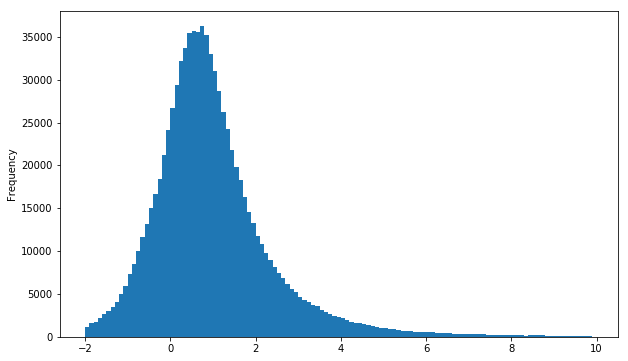

In [14]:
df_an_versp.plot.hist(bins=an_range, figsize=(10, 6))

In [15]:
df_ab_versp = df["VERSPAETUNG_AB"].dropna().apply(lambda d: d.total_seconds() / 60.0)

In [16]:
df_ab_versp.head(15)

1     0.933333
3     0.583333
5     0.466667
7     0.500000
9     0.600000
11    0.633333
13    0.416667
15    0.600000
17    0.466667
19    0.683333
21    0.550000
23    0.483333
25    0.466667
27    0.516667
29    0.333333
Name: VERSPAETUNG_AB, dtype: float64

In [17]:
len(df_ab_versp)

903100

In [18]:
ab_range = np.arange(-2, 10, 0.1)

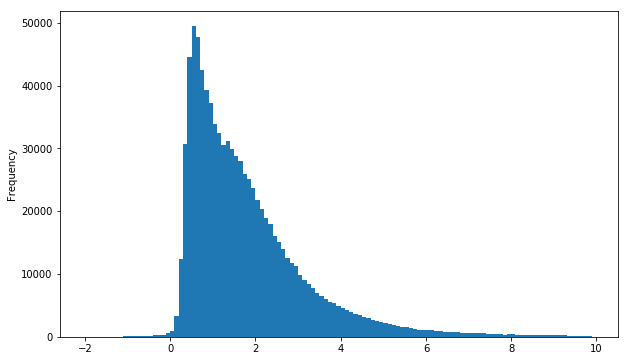

In [19]:
df_ab_versp.plot.hist(bins=ab_range, figsize=(10, 6))

In [44]:
x = df_an_versp[:1000]
d, p = scipy.stats.kstest(x, 'norm', (0.57737691, 1.12254617))

In [45]:
print d
print p

0.03830497119412968
0.10359721486162615


In [30]:
st.norm.fit(x)

(0.7085499999999999, 1.4630229199047657)

In [31]:
scipy.stats.kstest(df_an_versp[:100], 'norm')

KstestResult(statistic=0.3412726940595604, pvalue=6.71492576359145e-11)

In [58]:
res = optimize('norm', df_an_versp[:1000])
print res
print res.x

 final_simplex: (array([[0.57737691, 1.12254617],
       [0.57732317, 1.12259876],
       [0.5773791 , 1.12245204]]), array([0.03830497, 0.03830531, 0.0383102 ]))
           fun: 0.0383049701386633
       message: 'Optimization terminated successfully.'
          nfev: 69
           nit: 37
        status: 0
       success: True
             x: array([0.57737691, 1.12254617])
[0.57737691 1.12254617]


In [21]:
mu = df_an_versp.sum() / len(df_an_versp)
print mu
rho = (((df_an_versp - mu) ** 2).sum() / len(df_an_versp))**0.5
print rho

1.030665969929204
1.867008889399377


In [100]:
h[0].sum()

48.0

In [56]:
df_an_versp_sorted = sorted(df_an_versp)

In [154]:
dist_names = [
    'alpha',
    'anglit',
    'arcsine',
    'beta',
    'betaprime',
    'bradford',
    'burr',
    'cauchy',
    'chi',
    'chi2',
    'cosine',
    'dgamma',
    'dweibull',
    'erlang',
    'expon',
    'exponnorm',
    'exponweib',
    'exponpow',
    'f',
    'fatiguelife',
    'fisk',
    'foldcauchy',
    'foldnorm',
    'frechet_r',
    'frechet_l',
    'genlogistic',
    'genpareto',
    'gennorm',
    'genexpon',
    'genextreme',
#     'gausshyper',
    'gamma',
    'gengamma',
    'genhalflogistic',
    'gilbrat',
    'gompertz',
    'gumbel_r',
    'gumbel_l',
    'halfcauchy',
    'halflogistic',
    'halfnorm',
    'halfgennorm',
    'hypsecant',
    'invgamma',
    'invgauss',
    'invweibull',
    'johnsonsb',
    'johnsonsu',
    'ksone',
    'kstwobign',
    'laplace',
    'levy',
    'levy_l',
#     'levy_stable',
    'logistic',
    'loggamma',
    'loglaplace',
    'lognorm',
    'lomax',
    'maxwell',
    'mielke',
    'nakagami',
    'ncx2',
#     'ncf',
    'nct',
    'norm',
    'pareto',
    'pearson3',
    'powerlaw',
    'powerlognorm',
    'powernorm',
#     'rdist',
    'reciprocal',
    'rayleigh',
    'rice',
    'recipinvgauss',
    'semicircular',
    't',
    'triang',
    'truncexpon',
    'truncnorm',
    'tukeylambda',
    'uniform',
    'vonmises',
    'vonmises_line',
    'wald',
    'weibull_min',
    'weibull_max',
    'wrapcauchy',
]

In [90]:
np.linspace(left, right, retstep=step)[0]

array([-5.        , -4.69387755, -4.3877551 , -4.08163265, -3.7755102 ,
       -3.46938776, -3.16326531, -2.85714286, -2.55102041, -2.24489796,
       -1.93877551, -1.63265306, -1.32653061, -1.02040816, -0.71428571,
       -0.40816327, -0.10204082,  0.20408163,  0.51020408,  0.81632653,
        1.12244898,  1.42857143,  1.73469388,  2.04081633,  2.34693878,
        2.65306122,  2.95918367,  3.26530612,  3.57142857,  3.87755102,
        4.18367347,  4.48979592,  4.79591837,  5.10204082,  5.40816327,
        5.71428571,  6.02040816,  6.32653061,  6.63265306,  6.93877551,
        7.24489796,  7.55102041,  7.85714286,  8.16326531,  8.46938776,
        8.7755102 ,  9.08163265,  9.3877551 ,  9.69387755, 10.        ])

In [99]:
left = -5.0
right = 10.0
step = 0.25
r = np.arange(left, right, step)
h_ = np.histogram(df_an_versp[:10000], r, density=True)
print h_[:10]
print len(r)
print len(h_[0])
print len(h_[1])
print h_[0].sum()

(array([0.00040306, 0.        , 0.00080613, 0.        , 0.00040306,
       0.00080613, 0.00080613, 0.00201532, 0.00322451, 0.0076582 ,
       0.01168884, 0.01773478, 0.02176542, 0.02539299, 0.04232164,
       0.06328094, 0.09673519, 0.12414349, 0.17734784, 0.23579202,
       0.29947602, 0.33051189, 0.34340992, 0.35429262, 0.2942362 ,
       0.25151149, 0.24345022, 0.1942765 , 0.14631197, 0.13623539,
       0.11285772, 0.08424023, 0.07376058, 0.05642886, 0.03748489,
       0.04232164, 0.02982668, 0.02257154, 0.02095929, 0.01652559,
       0.00967352, 0.00886739, 0.00806127, 0.00564289, 0.00846433,
       0.00322451, 0.00403063, 0.00483676, 0.0044337 , 0.00201532,
       0.00322451, 0.00161225, 0.00120919, 0.00201532, 0.00161225,
       0.00322451, 0.00161225, 0.00080613, 0.00241838]), array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1

In [109]:
r_middle = [(r[i] + r[i + 1]) / 2.0 for i in range(len(r) - 1)]

In [119]:
exp = st.norm.pdf(r_middle)
exp

TypeError: _parse_args() takes at least 2 arguments (1 given)

In [111]:
from scipy.stats import chisquare
chisquare(h_[0], f_exp=exp)

Power_divergenceResult(statistic=1948853842624530.2, pvalue=0.0)

In [118]:
print sum([(h_[0][i] - exp[i])**2 / exp[i] for i in range(len(r_middle))])
print sum([(h_[0][i] - exp[i])**2 / h_[0][i] for i in range(len(r_middle))])
print sum([(h_[0][i] - exp[i])**2 for i in range(len(r_middle))])

1948853842624530.2
inf
0.3021288916659383


d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [103]:
exp

3.9999994453441206

In [150]:
def optimize(dist_name, data, opt_type='kst'):
    dist = getattr(scipy.stats, dist_name)
    first_guess = dist.fit(data)
    def fun_eval(act_paras, opt_type=opt_type):
        if opt_type == 'kst':
            d, p = scipy.stats.kstest(data, dist_name, act_paras)
            return d
        elif opt_type == 'cst':
            left = -5.0
            right = 10.0000000000000001
            step = 0.25
            r = np.arange(left, right, step)
            hist_emp = np.histogram(data, r, density=True)[0]
            r_m = np.array([(r[i] + r[i + 1]) / 2.0 for i in range(len(r) - 1)])
            hist_exp = dist.pdf(r_m, *act_paras[:-2], loc=act_paras[-2], scale=act_paras[-1])
            return st.chisquare(hist_emp, f_exp=hist_exp).statistic
        elif opt_type == 'ss':
            left = -5.0
            right = 10.0000000000000001
            step = 0.25
            r = np.arange(left, right, step)
            hist_emp = np.histogram(data, r, density=True)[0]
            r_m = np.array([(r[i] + r[i + 1]) / 2.0 for i in range(len(r) - 1)])
            hist_exp = dist.pdf(r_m, *act_paras[:-2], loc=act_paras[-2], scale=act_paras[-1])
            return np.power(hist_emp - hist_exp, 2.0).sum()
        elif opt_type == 'as':
            left = -5.0
            right = 10.0000000000000001
            step = 0.25
            r = np.arange(left, right, step)
            hist_emp = np.histogram(data, r, density=True)[0]
            r_m = np.array([(r[i] + r[i + 1]) / 2.0 for i in range(len(r) - 1)])
            hist_exp = dist.pdf(r_m, *act_paras[:-2], loc=act_paras[-2], scale=act_paras[-1])
            return np.absolute(hist_emp - hist_exp).sum()
        else:
            raise ValueError("{} is not a valid argument".format(opt_type))
    opt_paras = minimize(fun_eval, first_guess, method='nelder-mead')
    return opt_paras

alpha
anglit
arcsine
beta
betaprime
bradford
burr
cauchy
chi
chi2
cosine
dgamma
dweibull
erlang
expon
exponnorm
exponweib
exponpow
f
fatiguelife
fisk
foldcauchy
foldnorm
frechet_r


d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `frechet_r` is deprecated!
The distribution `frechet_r` is a synonym for `weibull_min`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_min`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
  This is separate from the ipykernel package so we can avoid doing imports until
d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `frechet_r` is deprecated!
The distribution `frechet_r` is a synonym for `weibull_min`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_min`.  For the Frechet distribut

frechet_l


d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.
  This is separate from the ipykernel package so we can avoid doing imports until
d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribut

genlogistic
genpareto
gennorm
genexpon
genextreme
gamma
gengamma
genhalflogistic
gilbrat
gompertz
gumbel_r
gumbel_l
halfcauchy
halflogistic
halfnorm
halfgennorm
hypsecant
invgamma
invgauss
invweibull


d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\scipy\stats\_continuous_distns.py:3416: RuntimeWarning: overflow encountered in power
  xc1 = np.power(x, -c - 1.0)
d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\scipy\stats\_continuous_distns.py:3417: RuntimeWarning: overflow encountered in power
  xc2 = np.power(x, -c)
d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\scipy\stats\_continuous_distns.py:3419: RuntimeWarning: invalid value encountered in multiply
  return c * xc1 * xc2


johnsonsb
johnsonsu
ksone
kstwobign
laplace
levy
levy_l
logistic
loggamma
loglaplace
lognorm
lomax
maxwell
mielke


d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\scipy\stats\_continuous_distns.py:4578: RuntimeWarning: overflow encountered in power
  return k*x**(k-1.0) / (1.0+x**s)**(1.0+k*1.0/s)
d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\scipy\stats\_continuous_distns.py:4578: RuntimeWarning: invalid value encountered in true_divide
  return k*x**(k-1.0) / (1.0+x**s)**(1.0+k*1.0/s)


nakagami
ncx2
nct
norm
pareto
pearson3
powerlaw
powerlognorm
powernorm
reciprocal
rayleigh
rice
recipinvgauss
semicircular
t
triang
truncexpon
truncnorm
tukeylambda
uniform
vonmises
vonmises_line
wald
weibull_min
weibull_max
wrapcauchy


d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: `frechet_l` is deprecated!
The distribution `frechet_l` is a synonym for `weibull_max`; this historical
usage is deprecated because of possible confusion with the (quite different)
Frechet distribution.  To preserve the existing behavior of the program, use
`scipy.stats.weibull_max`.  For the Frechet distribution (i.e. the Type II
extreme value distribution), use `scipy.stats.invweibull`.


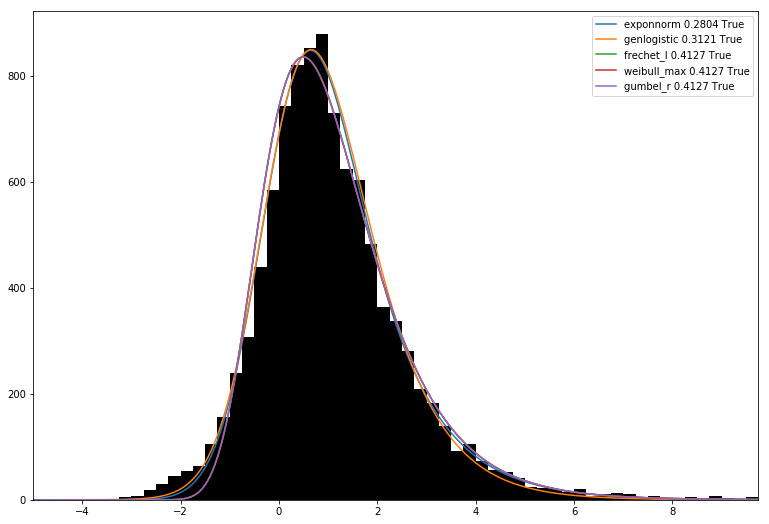

In [155]:
left = -5.0
right = 10.0
step = 0.25
x = np.arange(left, right, step)
y = np.array(df_an_versp[:10000])
plt.figure(figsize=(13,9))
h = plt.hist(y, bins=x, color='black', density=False)

# dist_names = [
#     'norm', 
#     'lognorm',
#     'weibull_min',
#      'weibull_max',
#     'alpha',
#     'cauchy',
#     'powerlognorm',
#     'chi',
#     'erlang',
#     'expon',
#     'gamma',
#     'gumbel_r',
#     'halfcauchy',
#     'maxwell',
#     'wald',
#     'levy',
# #     'levy_stable',
#     'levy_l',
#     'pareto',
# ]

res_per_dist_name = {}

for dist_name in dist_names:
    print dist_name
    try:
        res = optimize(dist_name, y, opt_type='as')
        res_per_dist_name[dist_name] = res
        param = res.x
#         print res
    except Exception as e:
        print "no success: {}".format(e)

sorted_dist_name_res_pairs = sorted(res_per_dist_name.items(), key=lambda p: p[1].fun)

for dist_name, res in sorted_dist_name_res_pairs[:5]:
        dist = getattr(scipy.stats, dist_name)
        param = res.x
        pdf_fitted = dist.pdf(np.arange(left, right, 0.05), *param[:-2], loc=param[-2], scale=param[-1]) * h[0].sum() * step
        plt.plot(np.arange(left, right, 0.05), pdf_fitted, label="{} {:.4f} {}".format(dist_name, res.fun, res.success))
        plt.xlim(x[0], x[-1])

plt.legend(loc='upper right')
plt.show()

In [54]:
def l(x, mu, rho):
    return np.sum(np.log(scipy.stats.norm.pdf(x, mu, rho)))

In [55]:
l(df_an_versp, 1.03, 1.86)

c:\dev\swiss-train-delay-distributions\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


-inf

In [52]:
np.log(2)

0.6931471805599453

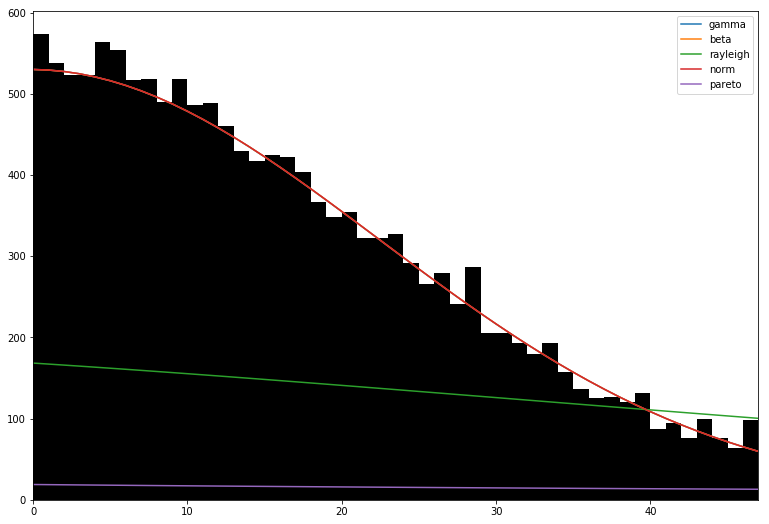

In [37]:
size = 30000
x = scipy.arange(size)
y = scipy.int_(scipy.round_(scipy.stats.vonmises.rvs(5,size=size)*47))
plt.figure(figsize=(13,9))
h = plt.hist(y, bins=range(48), color='black')

dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,47)
plt.legend(loc='upper right')
plt.show()

In [70]:
DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
]

In [74]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
l = [x.name for x in DISTRIBUTIONS]
pp.pprint(l)


[   'alpha',
    'anglit',
    'arcsine',
    'beta',
    'betaprime',
    'bradford',
    'burr',
    'cauchy',
    'chi',
    'chi2',
    'cosine',
    'dgamma',
    'dweibull',
    'erlang',
    'expon',
    'exponnorm',
    'exponweib',
    'exponpow',
    'f',
    'fatiguelife',
    'fisk',
    'foldcauchy',
    'foldnorm',
    'frechet_r',
    'frechet_l',
    'genlogistic',
    'genpareto',
    'gennorm',
    'genexpon',
    'genextreme',
    'gausshyper',
    'gamma',
    'gengamma',
    'genhalflogistic',
    'gilbrat',
    'gompertz',
    'gumbel_r',
    'gumbel_l',
    'halfcauchy',
    'halflogistic',
    'halfnorm',
    'halfgennorm',
    'hypsecant',
    'invgamma',
    'invgauss',
    'invweibull',
    'johnsonsb',
    'johnsonsu',
    'ksone',
    'kstwobign',
    'laplace',
    'levy',
    'levy_l',
    'levy_stable',
    'logistic',
    'loggamma',
    'loglaplace',
    'lognorm',
    'lomax',
    'maxwell',
    'mielke',
    'nakagami',
    'ncx2',
    'ncf',
    'nc

In [26]:
y, x = np.histogram(list(df_an_versp), bins=)
for distribution in [st.norm, st.lognorm]:
    print distribution
    try:
        params = distribution.fit(list(df_ab_versp))
        print params
    except Exception as e:
        print e

(1.8730592957590526, 1.9505348885236902)
(0.029979520487039578, -65.99999974593283, 67.8501667811208)


d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

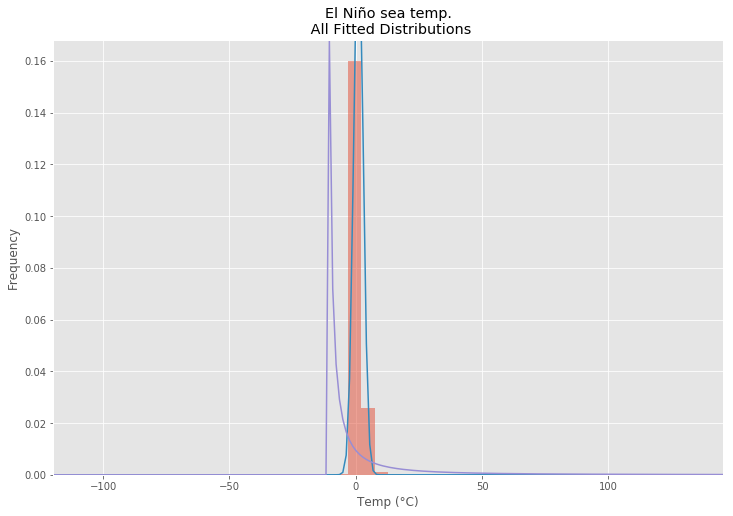

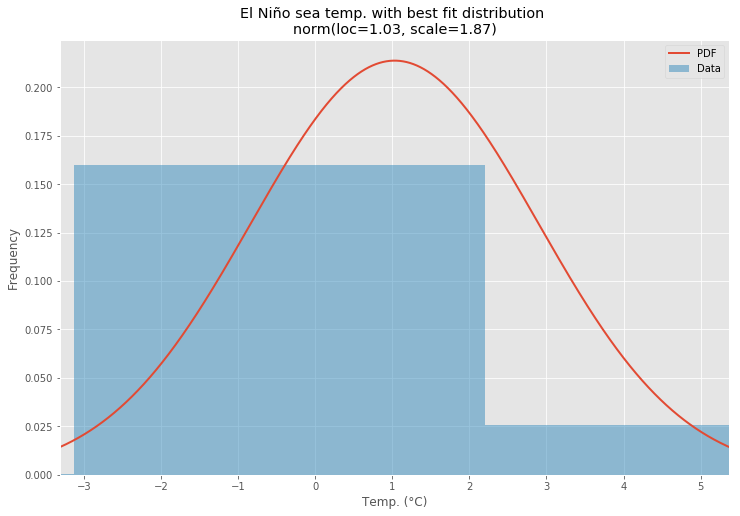

In [30]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=an_range, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
#         st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
#         st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
#         st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
#         st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
#         st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
#         st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
#         st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
#         st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
#         st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
#         st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
        st.norm,
        st.lognorm
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = df_an_versp

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5,
#                color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')